In [35]:
pip install tensorflow

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

np.random.seed(2)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

import tensorflow
from tensorflow.keras import utils
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau



sns.set(style='white', context='notebook', palette='deep')

In [37]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

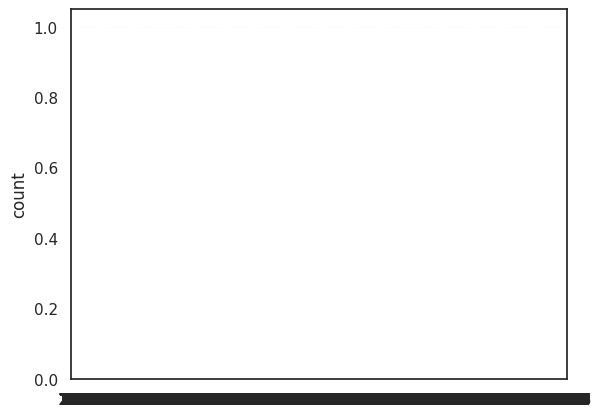

In [38]:
Y_train = train["label"]

X_train = train.drop(labels = ["label"],axis = 1)

del train

g = sns.countplot(Y_train)

Y_train.value_counts()

In [39]:
X_train.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

In [40]:
test.isnull().any().describe()

count      784
unique       2
top       True
freq       436
dtype: object

In [41]:
X_train = X_train / 255.0
test = test / 255.0

In [42]:
X_train = X_train.values.reshape(-1,28,28,1)
test = test.values.reshape(-1,28,28,1)

In [43]:
Y_train = to_categorical(Y_train, num_classes = 10)

In [44]:
random_seed = 2

In [45]:
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.1, random_state=random_seed)

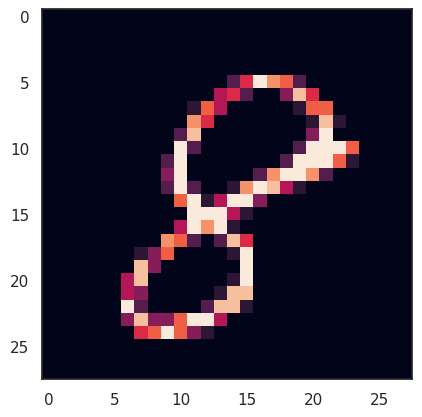

In [47]:
g = plt.imshow(X_train[0][:,:,0])

In [48]:
model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',
                 activation ='relu', input_shape = (28,28,1)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same',
                 activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation = "softmax"))

In [49]:
optimizer = tensorflow.keras.optimizers.legacy.Adam(lr=0.001, epsilon=1e-08, decay=0.0)

model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/legacy/adam.py:118: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [50]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc',
                                            patience=3,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.00001)

In [51]:
epochs = 1
batch_size = 86

In [52]:


datagen = ImageDataGenerator(
        featurewise_center=False,
        samplewise_center=False,
        featurewise_std_normalization=False,
        samplewise_std_normalization=False,
        zca_whitening=False,
        rotation_range=10,
        zoom_range = 0.1,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=False,
        vertical_flip=False)

datagen.fit(X_train)

In [53]:
history = model.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,Y_val),
                              verbose = 2, steps_per_epoch=X_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])

<ipython-input-53-00f8d670f626>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),


439/439 - 245s - loss: 0.4047 - accuracy: 0.8682 - val_loss: 0.0570 - val_accuracy: 0.9824 - lr: 0.0010 - 245s/epoch - 557ms/step


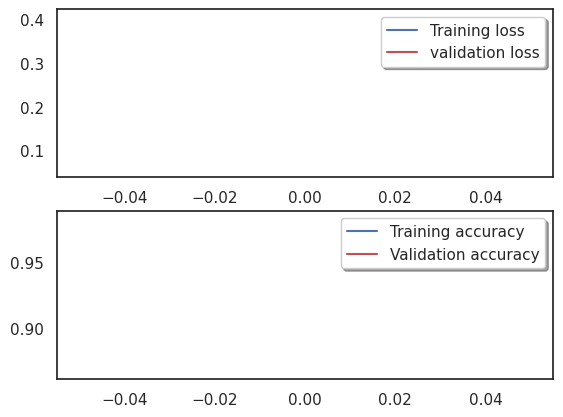

In [54]:
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

132/132 [==============================] - 7s 50ms/step


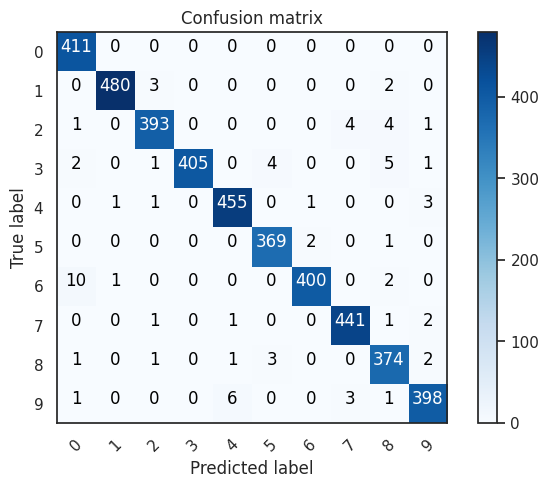

In [55]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Y_pred = model.predict(X_val)

Y_pred_classes = np.argmax(Y_pred,axis = 1)

Y_true = np.argmax(Y_val,axis = 1)

confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)

plot_confusion_matrix(confusion_mtx, classes = range(10))

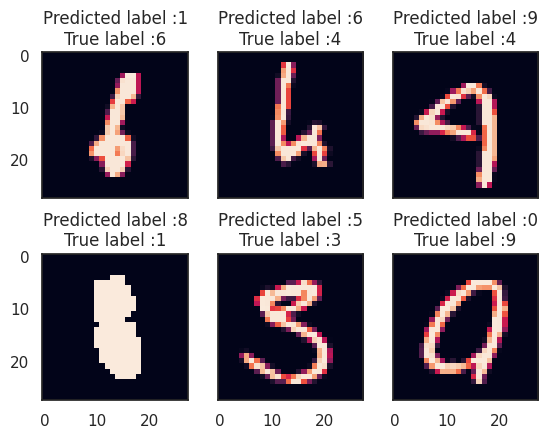

In [56]:
errors = (Y_pred_classes - Y_true != 0)

Y_pred_classes_errors = Y_pred_classes[errors]
Y_pred_errors = Y_pred[errors]
Y_true_errors = Y_true[errors]
X_val_errors = X_val[errors]

def display_errors(errors_index,img_errors,pred_errors, obs_errors):
    """ This function shows 6 images with their predicted and real labels"""
    n = 0
    nrows = 2
    ncols = 3
    fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True)
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row,col].imshow((img_errors[error]).reshape((28,28)))
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(pred_errors[error],obs_errors[error]))
            n += 1

Y_pred_errors_prob = np.max(Y_pred_errors,axis = 1)

true_prob_errors = np.diagonal(np.take(Y_pred_errors, Y_true_errors, axis=1))

delta_pred_true_errors = Y_pred_errors_prob - true_prob_errors

sorted_dela_errors = np.argsort(delta_pred_true_errors)

most_important_errors = sorted_dela_errors[-6:]

display_errors(most_important_errors, X_val_errors, Y_pred_classes_errors, Y_true_errors)

In [57]:
results = model.predict(test)

results = np.argmax(results,axis = 1)

results = pd.Series(results,name="Label")

90/90 [==============================] - 6s 62ms/step


In [58]:
print("Accuracy:", history.history['accuracy'][-1])

Accuracy: 0.868218719959259
